In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import sin, cos
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [ ]:
def one_hot_target(target_val):
  one_hotted = np.zeros(8)
  target_val = int(target_val)
  if target_val < 1:
    one_hotted[target_val+4] = 1
  else:
    one_hotted[target_val+3] = 1
  return one_hotted

In [ ]:
data = pd.read_csv("/content/drive/My Drive/CS449_Project/CS_449_Data/full_dataset_4.csv")
data = data[['ticker','return', 'Volume', 'op_income_pre_dep', 'op_income_post_dep', 'sales_net', 'current_assets', 'current_liabilities', 'retained_earnings', 'working_capital','return group']].dropna()
print(data["return group"].unique())
# for i in data["return group"].unique():
#   print(one_hot_target(i))
print(data)

num_data_points = 10

need_multiple = num_data_points*data.shape[1]
# print(need_multiple)
trainX = []
trainY = []
for i in range(num_data_points):        #get data point groups, increment to ensure all combinations included
  seq_data = data[i:data.shape[0]]
  # print(seq_data.shape)
  seq_data = seq_data[0:seq_data.shape[0]-(seq_data.shape[0]%need_multiple)]
  seq_data = np.array(seq_data)
  seq_data = np.reshape(seq_data, (-1, num_data_points, data.shape[1]))
  # print(seq_data.shape)
  # print(seq_data)
  # print("__________________")
  filter_for_ticker_overlap = []
  for i in seq_data:
    no_overlap = True
    for d in range(1,num_data_points):
      if i[0][0] != i[d][0]:
        no_overlap = False
    filter_for_ticker_overlap.append(no_overlap)

  print("HERE",seq_data.shape)
  seq_data = seq_data[filter_for_ticker_overlap]
  print(seq_data.shape)
  train_filter = [False,True,False,True,True,True,True, True, True, True, False]
  # train_filter = [False,True,False,False,False,False, False, False, False, False, False, False]
  for data_point_set in seq_data:
    new_X_val = []
    for j in range(num_data_points):
      new_X_val.append(data_point_set[j][train_filter])
    trainX.append(new_X_val)
    trainY.append(one_hot_target(data_point_set[num_data_points-1][10]))
    # if (data_point_set[num_data_points-1][10]) < 0:
    #   trainY.append(0)
    # else:
    #   trainY.append(1)

trainX = np.array(trainX)
trainX = trainX.astype(float)
trainY = np.array(trainY)
trainY = trainY.astype(float)

print("--------------")
# print(trainY)
# print(np.argmax(trainY, axis=1))

trainY_classes = np.argmax(trainY, axis=1)
min_class_samples = min(np.bincount(trainY_classes))
print(min_class_samples)
undersampled_X = []
undersampled_y = []
for label in np.unique(trainY_classes):             #make all bins the same size; no more imbalanced data
    matching = np.where(trainY_classes == label)[0]
    # print("matching=",matching)
    chosen = np.random.choice(matching, size=min_class_samples, replace=False)
    undersampled_X.extend(trainX[chosen])
    undersampled_y.extend(trainY[chosen])

# print(np.bincount(np.argmax(undersampled_y, axis=1)))

undersampled_X = np.array(undersampled_X)
undersampled_X = undersampled_X.astype(float)
undersampled_y = np.array(undersampled_y)
undersampled_y = undersampled_y.astype(float)

x, x_test, y, y_test = train_test_split(undersampled_X, undersampled_y, test_size=0.1, shuffle=True)
# x, x_test, y, y_test = train_test_split(trainX, trainY, test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, shuffle=True)

# print(trainY[0:5])
# print(trainX[0])

[ 4. -4. -1.  1.  3.  2. -3. -2.]
      ticker     return      Volume  op_income_pre_dep  op_income_post_dep  \
1        AAL  90.385527  -31.306631         310.714286               402.0   
2        AAL  26.349981   32.701002         313.913043               767.0   
3        AAL -70.894338   -5.591655        -109.453782               265.0   
4        AAL -39.428968   18.326575         315.555556               122.0   
5        AAL -71.941634  112.586071         -32.620321               198.0   
...      ...        ...         ...                ...                 ...   
38405   ALLE  11.179367  -14.015854          10.967251               166.2   
38406   ALLE  -4.865881   79.737152          -2.402196               162.3   
38407   ALLE   0.471516  -69.398669         -18.846695               136.5   
38408   ALLE -16.804949  190.335235           5.979203               142.7   
38409   ALLE -10.459127    3.869304          24.284546               171.7   

       sales_net  current_ass

In [ ]:
from tensorflow.keras import backend as K

risk_factor = 0.5

def custom_BCE(y_true, y_pred, weight_factor = 1.0):
  epsilon = K.epsilon()
  y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
  loss = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0-y_pred))
  false_negatives = tf.logical_and(tf.equal(y_true, 1), tf.less(y_pred, risk_factor))
  false_negatives_loss = loss * weight_factor
  loss = tf.where(false_negatives, false_negatives_loss, loss)
  return K.mean(loss)

In [ ]:
# from tensorflow.keras.losses import CategoricalCrossentropy

# loss = tf.losses.MeanSquaredError()
loss = tf.losses.BinaryCrossentropy()
# loss = tf.losses.MeanSquaredLogarithmicError()
model = Sequential()
model.add(LSTM(8, input_shape=(num_data_points, undersampled_X.shape[2])))
# model.add(LSTM(8, input_shape=(num_data_points, trainX.shape[2])))
model.add(Dense(8, activation='softmax'))
# model.add(Dense(1))
weight_factor = 1
lr = 0.002
epochs = 200
# loss = CategoricalCrossentropy()
# model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryCrossentropy()])
# model.compile(loss=lambda y_true, y_pred: custom_BCE(y_true, y_pred, weight_factor=weight_factor), optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=[lambda y_true, y_pred: custom_BCE(y_true, y_pred, weight_factor=weight_factor)])
# model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])


# history = model.fit(trainX, trainY, validation_split=0.33, epochs=epochs, batch_size=64, verbose=2, validation_steps=30)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=2, validation_data=(x_val, y_val))

Epoch 1/200
219/219 - 5s - loss: 0.5048 - accuracy: 0.1334 - val_loss: 0.3993 - val_accuracy: 0.1230 - 5s/epoch - 21ms/step
Epoch 2/200
219/219 - 2s - loss: 0.3902 - accuracy: 0.1361 - val_loss: 0.3877 - val_accuracy: 0.1307 - 2s/epoch - 8ms/step
Epoch 3/200
219/219 - 2s - loss: 0.3851 - accuracy: 0.1466 - val_loss: 0.3851 - val_accuracy: 0.1339 - 2s/epoch - 10ms/step
Epoch 4/200
219/219 - 2s - loss: 0.3829 - accuracy: 0.1422 - val_loss: 0.3834 - val_accuracy: 0.1301 - 2s/epoch - 8ms/step
Epoch 5/200
219/219 - 1s - loss: 0.3811 - accuracy: 0.1485 - val_loss: 0.3820 - val_accuracy: 0.1326 - 1s/epoch - 7ms/step
Epoch 6/200
219/219 - 2s - loss: 0.3798 - accuracy: 0.1452 - val_loss: 0.3805 - val_accuracy: 0.1333 - 2s/epoch - 7ms/step
Epoch 7/200
219/219 - 2s - loss: 0.3786 - accuracy: 0.1499 - val_loss: 0.3792 - val_accuracy: 0.1404 - 2s/epoch - 7ms/step
Epoch 8/200
219/219 - 2s - loss: 0.3778 - accuracy: 0.1488 - val_loss: 0.3783 - val_accuracy: 0.1533 - 2s/epoch - 7ms/step
Epoch 9/200
21

In [ ]:
# test_num = 700
# print(trainX[test_num].shape)
# test = trainX[test_num]
# test = np.reshape(test, (-1, 3, 10))
# print(test.shape)
# print(model.predict(test))
# print(trainY[test_num])
# print(trainX.shape[2])

(3, 9)


ValueError: ignored

In [ ]:
test_prediction = model.predict(x_test)
# loss = tf.losses.CategoricalCrossentropy(test_prediction,y_test)
# print(loss)
classes = tf.argmax(test_prediction, axis=1)
print(classes)
correct = 0
correct_up_down = 0
correct_within_one = 0
for i in range(len(classes)):
  pred = classes[i]
  if y_test[i][pred] == 1:
    correct += 1
  if (pred >= 4 and np.argmax(y_test[i]) >= 4) or  (pred < 4 and np.argmax(y_test[i]) < 4):
    correct_up_down += 1
  if np.abs(np.argmax(y_test[i])-pred) <= 1:
    correct_within_one += 1 

test_accuracy = correct / len(classes)
test_up_down_accuracy = correct_up_down / len(classes)
test_within_one_accuracy = correct_within_one / len(classes)
print(f"Test accuracy: {test_accuracy}")
print(f"Test gain vs. loss accuracy: {test_up_down_accuracy}")
values, counts = np.unique(classes, return_counts=True)
print(f"Prediction distribution: {counts}")
classes = tf.argmax(y_test, axis=1)
values, counts = np.unique(classes, return_counts=True)
print(f"Real test distribution: {counts}")


54/54 [==============================] - 1s 4ms/step
tf.Tensor([0 5 1 ... 5 5 7], shape=(1726,), dtype=int64)
Test accuracy: 0.15758980301274622
Test gain vs. loss accuracy: 0.5028968713789108
Prediction distribution: [290 143   7  25  20 845  68 328]
Real test distribution: [204 192 243 234 222 196 213 222]


54/54 [==============================] - 1s 3ms/step
tf.Tensor([0 5 7 ... 5 5 0], shape=(1726,), dtype=int64)


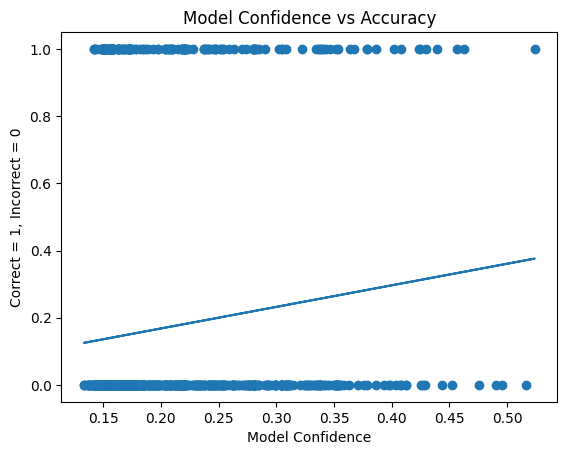

In [ ]:
#testing correlation between model confidence and accuracy
from sklearn.linear_model import LinearRegression
pairs = []
test_prediction = model.predict(x_test)
classes = tf.argmax(test_prediction, axis=1)
print(classes)
confs = []
corrects = []
for i in range(len(test_prediction)):
  pred = classes[i]
  # print(test_prediction[i][pred])
  confidence = test_prediction[i][pred]
  correct = y_test[i][pred]                    # =1 if correct, 0 if not  
  pairs.append([confidence, correct])
  confs.append(confidence)
  corrects.append(correct)
pairs = np.array(pairs)
confs = np.array(confs)
corrects = np.array(corrects)
# print(pairs)
confs = confs.reshape(-1, 1)
corrects = corrects.reshape(-1, 1)
plt.plot(confs, LinearRegression().fit(confs, corrects).predict(confs))
plt.ylabel("Correct = 1, Incorrect = 0")
plt.xlabel("Model Confidence")
plt.title("Model Confidence vs Accuracy")
plt.scatter(confs, corrects)

In [ ]:
# # for binary
# test_prediction = model.predict(x_test)
# print(test_prediction)
# classes = np.where(test_prediction < 0.5, 0, 1)
# print(classes)
# values, counts = np.unique(classes, return_counts=True)
# print(values, counts)

84/84 [==============================] - 0s 2ms/step
[[0.63171357]
 [0.58097565]
 [0.51289964]
 ...
 [0.680658  ]
 [0.57843107]
 [0.5807422 ]]
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[0 1] [  84 2586]


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

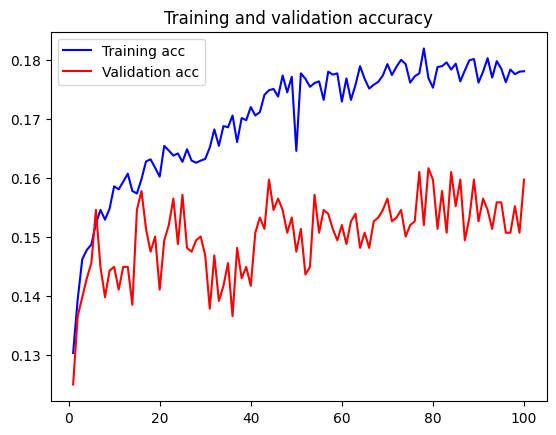

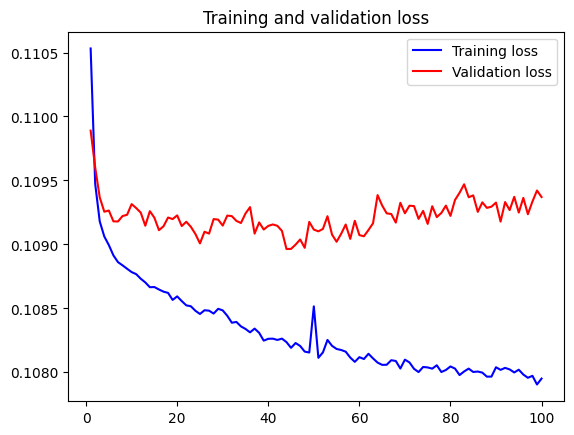

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()